# The Transformer Architecture

- Encoder : Converts an input sequence of tokens into a sequence of embedding vectors, often called the _hidden state_ or _context_
- Decoder : Uses the encoder's hidden state to iteratively generate an output sequence of tokens, one token at a time

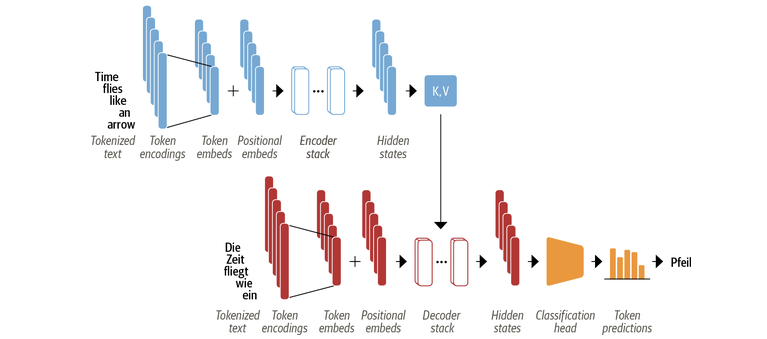

# The Encoder

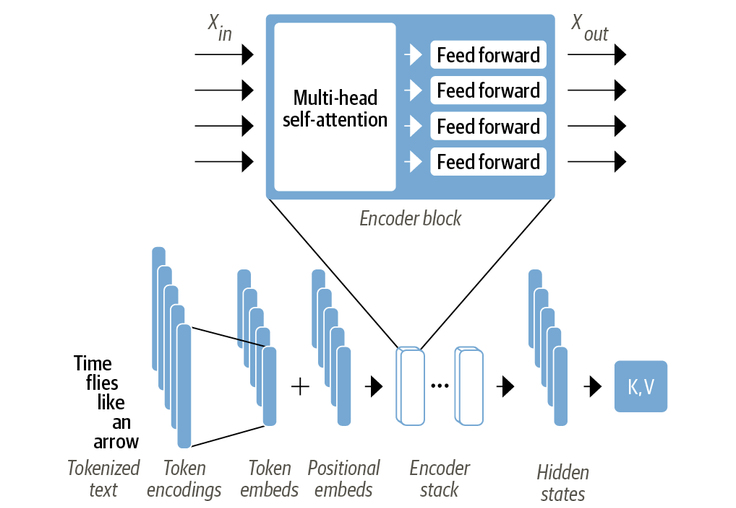

The transformer's encoder consists of many encoder layers stacked next to each others. Each encoder layer receives a sequence of embeddings and feeds them through the following sublayers:

- A multi-head self-attention layer
- A fully connected feed-forward layer that is applied the each input embedding

## Self-Attention

The main idea behind self-attention is that instead of using a fixed embedding for each token, we can use the whole sequence to compute a _weighted average_ of each embedding. Another way to formulate this is to say that given a sequence of token embedding $x_1, \cdots, x_n$, self-attention produces a sequence of new embeddings $x'_1, \cdots, x'_n$ where each $x'_i$ is a linear combination of all the $x_j$:

$$ x'_i = \sum_{j=1}^{n}w_{ji}x_j $$

The coefficients $w_{ji}$ are called _attention weights_ and are normalized so that $\sum_j w_{ji} = 1$.

### Scaled dot-product attention

There are several ways to implement a self-attention layer, but the most common one is _scaled dot-product attention_, from the paper introducing the Transformer architecture. There are main steps required to implement this mechanisum:

1. Project each token embedding into three vectors called _query_, _key_, and _value_.
2. Compute attention scores. We determine how much the query and key vectors relate to each other using a _similarity function_. As the name suggests, the similarity fufnction for scaled dot-product attention is the dot product, computed efficiently using matrix multiplication of the embddings. The outputs from this step are called the _attention scores_, and for a sequence with $n$ input tokens there is a corresponding $n \times n$ matrix of attention scores.
3. Compute attention weights. Dot products can in general produce arbitrarily large numbers, which can destabilize the training process. To handle this, the attention scores are first multiplied by a scaling factor to normalize their variance and then normalized with a softmax to ensure all the column values sum to 1. The resuling $n \times n$ matrix now contains all the attention weights, $w_{ji}$.
4. Update the token embeddings. Once the attention weights are computed, we multiply them by the value vector $v_1, \cdots, v_n$ to obtain an updated representation for embedding $x'_i = \sum_j w_{ji}v_j$.

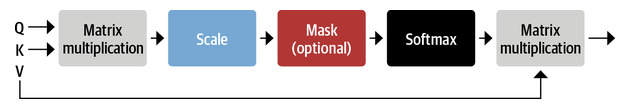

We can visualize how the attention weights are calculated with a nifty library called **BertViz**.

In [3]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = "time files like an arrow"
show(model, "bert", tokenizer, text, display_mode="light", layer=0, head=8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# Before implementing the Transformer architecture, the first thing we need to do is tokenize the text.
# So let's use out tokenizer to extract the input IDs:
# To keep things simple, we've also excluded the [CLS] and [SEP] tokens by `add_special_tokends=False`.
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False)
inputs.input_ids

tensor([[2051, 6764, 2066, 2019, 8612]])

In [8]:
# Next, we need to create some dense embeddings.
# In pytorch, we can do this by using a `torch.nn.Embedding` layer that acts as a lookup table for each input ID:
from torch import nn
from transformers import AutoConfig

# here we've used the `AutoConfig` class to load the `config.json` file associated with the `bert-base-uncased` checkpoint.
# In Transformers(huggingface), every checkpoint is assigned a configuration file that specifies various hyperparameters like
# `vocab_size` and `hidden_size`, which in out example shows us that each input ID will be mapped to one of the 30,522 embedding
# vectors stored in nn.Embedding, each with a size of 768.
config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(30522, 768)

In [9]:
# Now that we have our lookup table, we can generate the embeddings by feeding in the input IDs:
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.size()

torch.Size([1, 5, 768])

In [10]:
# This has given us a tensor of shape [batch_size, seq_len, hidden_dim]. (skip the positional encodings)
# The next step is to create the query, key, and value vectors and calculate the attention scores using 
# the dot product as the similarity function:
import torch
from math import sqrt

query = key = value = inputs_embeds
dim_k = key.size(-1)
scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
scores.size()

torch.Size([1, 5, 5])

In [11]:
# This has created a 5 x 5 matrix of attention scores per sample in the batch.
# We'll see later that the query, key, and value vectors are generated by applying independent weight matrices W_Q, W_K, W_V
# to the embeddings, but for now we've kept them equal for simplicity.
# In scaled dot-product attention, the dot products are scaled by the size of the embedding vectors so that we don't get
# too many large numbers during trainig that can cause the softmax we will apply next to saturate.
# Let's apply the softamx now:
import torch.nn.functional as F

weights = F.softmax(scores, dim=-1)
weights.sum(dim=-1)

tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

In [12]:
# The final step is to multiply the attention weights by the values:
attn_outputs = torch.bmm(weights, value)
attn_outputs.shape

torch.Size([1, 5, 768])

In [13]:
# Let's wrap these steps into a function that we can use later:
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)

### Multi-headed attention

In practice, the self-attention layer applies three independent linear transformations to each embeddings to generate the query, key, and value vectors. Theses transformation project the embeddings and each projection carries its own set of learnable parameters, which allows t he self-attention layer to focus on different semantic aspects of the sequence.

It also turns out to be beneficial to have *multiple* sets of linear projections, each one representing a so-called *attention head*. The resuling *multi-head attention layer* is illustraed below.

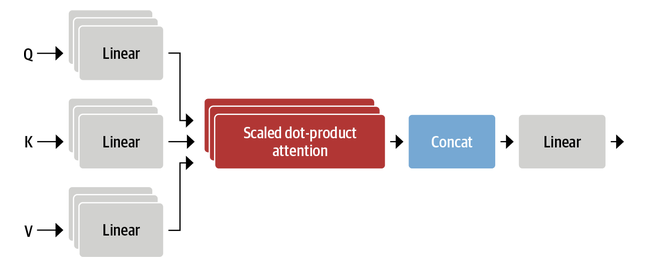

In [14]:
# Let's implement this layer by first coding up a single attention head:
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state)
        )
        return attn_outputs

Here we've initialized three independent linear layers that apply matrix multiplication to the embedding vectors to produce tensors of shape [batch_size, seq_len, head_dim], where `head_dim` is the number of dimensions we are projecting into. Although `head_dim` does not have to be smaller than the number of embedding dimensions of the tokens(`embed_dim`), in practice it is chosen to be a multiple of `embed_dim` so that the computation across each head is constant. For example, BERT has 12 attention heads, so the dimension of each head is 768/12 = 64.

In [17]:
# Now that we have a single attention head, we can concatenate the outputs of each one
# to implement the full multi-head attention layer:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

In [18]:
# Notice that the concatenated output from the attention heads is also fed through a final linear layer
# to produce an output tensor of shape [batch_size, seq_len, hidden_dim] that is suitable for the feed-forward network downstream.

multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)
attn_output.size()

torch.Size([1, 5, 768])

To wrap up this section on attention, let's use BertViz again to visualize the attention for two different uses of the word "files". Here we can use the `head_view()` function from BertVis by computing the attentions of a pretrained checkpoint and indicating where the sentence boundary lies:

In [21]:
from bertviz import head_view
from transformers import AutoModel

model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)

sentence_a = "time files like an arrow"
sentence_b = "fruit files like a banana"

viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors="pt")
attention = model(**viz_inputs).attentions
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])

head_view(attention, tokens, sentence_b_start, heads=[8])

<IPython.core.display.Javascript object>

This visualization shows the attention weights as lines connecting the token whose embedding is getting updated (left) with every word that is being attended to (right).

In this example, the input consists of two sentences and the [CLS] and [SEP] tokens are the special tokens in BERT's tokenizer. One thing we can see from the visualization is that the attention weights are strongest between words that belong to the same sentence, which suggests BERT can tell that it should attend to words in the same sentence. However, for the word “flies” we can see that BERT has identified “arrow” as important in the first sentence and “fruit” and “banana” in the second. These attention weights allow the model to distinguish the use of “flies” as a verb or noun, depending on the context in which it occurs!

## The Feed-Forward Layer

The feed-forward sublayer in the encoder and decoder is just a simple two-layer fully connected neural network, but with a twist: instead of processing the whole sentence of embeddings as a single vector, it processes each embedding *independently*. For this reason, this layer is often referred to as a *position-wise feed-forward layer*. You may also see it referred to as a one-dimensional convolution with a kernel size of one, typically by people with a computer vision background (e.g., the OpenAI GPT codebase uses this nomenclature). A rule of thumb from the literature is for the hidden size of the first layer to be four times the size of the embeddings, and a GELU activation function is most commonly used. This is where most of the capacity and memorization is hypothesized to happen, and it's the part that is most often scaled when scaling up the models.

In [22]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x

In [23]:
feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_outputs)
ff_outputs.size()

torch.Size([1, 5, 768])

## Adding Layer Normalization

The transformer architecture makes use of *layer normalization* and *skip connections*. The former normalizes each input in the batch to have zero mean and unity variance. Skip connections pass a tensor to the next layer of the model without processing and add it to the processed tensor. When it comes to placing the layer normalization in the encoder or decoder layers of a transformer, there are two main choices adopted in the literature:

- *Post layer normalization*

  This is the arrangement used in the Transformer paper; it places layer normalization in between the skip connections. This arrangement is tricky to train from scratch as the gradients can diverge. For this reason, you will often see a concept known as *learning rate warm-up*, where the learning rate is gradually increased from a small value to some maximum value during training.
- *Pre layer normalization*

  This is the most common arrangement found in the literature; it places layer normalization within the span of the skip connections. This tends to be much more stable during training, and it does not usually require any learning rate warm-up.

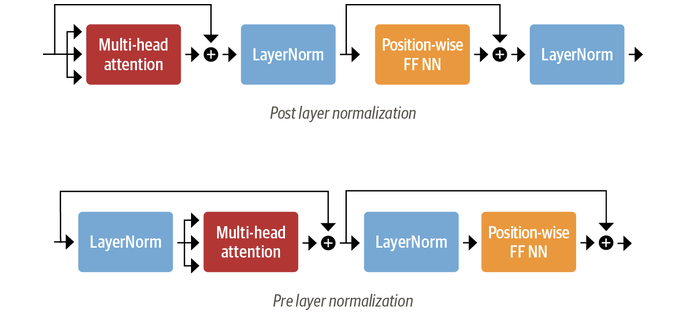

In [24]:
# We'll use the second arrangement, so we can simply stick together out building blocks as follows:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        # apply attention with a skip connection
        x = x + self.attention(hidden_state)
        # apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

In [25]:
encoder_layer = TransformerEncoderLayer(config)
inputs_embeds.shape, encoder_layer(inputs_embeds).size()

(torch.Size([1, 5, 768]), torch.Size([1, 5, 768]))

## Positional Embeddings

Positional embeddings are based on a simple, yet very effective idea: augment the token embeddings with a position-dependent pattern of values arranged in a vector. If the pattern is characteristic for each position, the attention heads and feed-forward layers in each stack can learn to incorporate positional information into their transformations.

There are several ways to achieve this, and one of the most popular approaches is to use a learnable pattern, especially when the pretraining dataset is sufficiently large. This works exactly the same way as the token embeddings, but using the position index instead of the token ID as input. With that approach, an efficient way of encoding the positions of tokens is learned during pretraining.

In [28]:
# let's create a custom Embeddings module that combines a token embedding layer that projects the `input_ids`
# to a dense hidden state together with the positional embedding that does the same for `position_ids`.
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout()

    def forward(self, input_ids):
        # create position IDs for input sequence
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        # create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

In [29]:
embedding_layer = Embeddings(config)
embedding_layer(inputs.input_ids).size()

torch.Size([1, 5, 768])

In [30]:
# Let's put all of this together now by building the full transformer encoder combining the embeddings with the encoder layers:
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList(
            [TransformerEncoderLayer(config) for _ in range(config.num_hidden_layers)]
        )

    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        return x

In [31]:
encoder = TransformerEncoder(config)
encoder(inputs.input_ids).size()

torch.Size([1, 5, 768])

In [32]:
print(encoder)

TransformerEncoder(
  (embeddings): Embeddings(
    (token_embeddings): Embedding(30522, 768)
    (position_embeddings): Embedding(512, 768)
    (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (layer_norm_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layer_norm_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-11): 12 x AttentionHead(
            (q): Linear(in_features=768, out_features=64, bias=True)
            (k): Linear(in_features=768, out_features=64, bias=True)
            (v): Linear(in_features=768, out_features=64, bias=True)
          )
        )
        (output_linear): Linear(in_features=768, out_features=768, bias=True)
      )
      (feed_forward): FeedForward(
        (linear_1): Linear(in_features=768, out_features=3072, b

## Adding a Classification Head

Transformer models are usually divided into a task-independent body and a task-specific head. What we have built so far is the body, so if we wish to build a text classifier, we will need to attach a classification head to that body. We have a hidden state for each token, but we only need to make one prediction. There are several options to approach this. Traditionally, the first token in such models is used for the prediction and we can attach a dropout and a linear layer to make a classification prediction. The following class extends the existing encoder for sequence classification:

In [36]:
class TransformerForSequenceClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = TransformerEncoder(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, x):
        x = self.encoder(x)[:, 0, :] # select hidden state of [CLS] token
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [37]:
config.num_labels = 3
encoder_classifier = TransformerForSequenceClassification(config)
encoder_classifier(inputs.input_ids).size()

torch.Size([1, 3])

# The Decoder

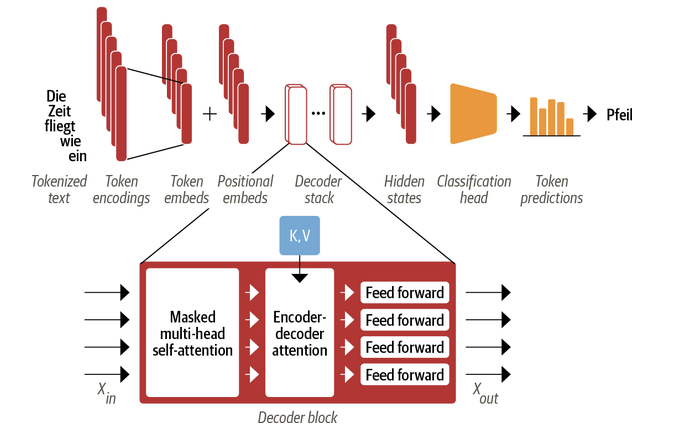

As illustrated above, the main difference between the decoder and encoder is that the decoder has *two* attention sublayers:

- *Masked multi-head self-attention layer*

  Ensures that the tokens we generate at each timestep are only based on the past outputs and the current token being predicted. Without this, the decoder could cheat during training by simply copying the target translations; masking the inputs ensures the task is not trivial.

- *Encoder-decoder attention layer*

  Performs multi-head attention over the output key and value vectors of the encoder stack, with the intermediate representations of the decoder acting as the queries. This way the encoder-decoder attention layer learns how to relate tokens from two different sequences, such as two different languages. The decoder has access to the encoder keys and values in each block.

In [39]:
# Let's take a look at the modifications we need to make to include masking in our self-attention layer.
# The trick with masked self-attention is to introduce a mask matrix with ones on the lower diagonal and zeros above:
seq_len = inputs.input_ids.size(-1)
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
mask[0]

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

In [40]:
# Here we've used PyTorch's tril() function to create the lower triangular matrix.
# Once we have this mask matrix, we can prevent each attention head from peeking at future tokens
# by using Tensor.masked_fill() to replace all the zeros with negative infinity:
scores.masked_fill(mask == 0, -float("inf"))

tensor([[[29.2514,    -inf,    -inf,    -inf,    -inf],
         [-0.9443, 26.2229,    -inf,    -inf,    -inf],
         [ 0.1002, -0.6794, 29.7639,    -inf,    -inf],
         [ 0.5213, -0.1140,  1.1945, 26.3517,    -inf],
         [ 0.5674,  1.7784,  1.0148,  1.4144, 29.9796]]],
       grad_fn=<MaskedFillBackward0>)

By setting the upper values to negative infinity, we guarantee that the attention weights are all zero once we take the softmax over the scores because $e^{-\infty} = 0$ (recall that softmax calculates the normalized exponential). We can easily include this masking behavior with a small change to our scaled dot-product attention function that we implemented earlier in this chapter:

In [46]:
def scaled_dot_product_attention(query, key, value, mask=None):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-inf"))
    weights = F.softmax(scores, dim=-1)
    return weights.bmm(value)

In [47]:
class MaskedAttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        seq_len = hidden_state.size(1)
        mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state), mask=mask
        )
        return attn_outputs

class MaskedMultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [MaskedAttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

In [48]:
masked_multihead_attn = MaskedMultiHeadAttention(config)
masked_attn_output = masked_multihead_attn(inputs_embeds)
masked_attn_output.size()

torch.Size([1, 5, 768])

In [49]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MaskedMultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        # apply attention with a skip connection
        x = x + self.attention(hidden_state)
        # apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

In [50]:
decoder_layer = TransformerDecoderLayer(config)
inputs_embeds.shape, decoder_layer(inputs_embeds).size()

(torch.Size([1, 5, 768]), torch.Size([1, 5, 768]))

In [53]:
class TransformerDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList(
            [TransformerDecoderLayer(config) for _ in range(config.num_hidden_layers)]
        )

    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        return x

In [54]:
TransformerDecoder(config)(inputs.input_ids).size()

torch.Size([1, 5, 768])